# Imports

In [1]:
import numpy as np
import pandas as pd

import statistics
#from scipy.stats import kurtosis, skew 


import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from __future__ import division


import os
regex=True


# Plotting Parameter Setup

In [2]:
fsize = 15.5
tsize = 10

tdir = 'in'

major = 3.0
minor = 3.0

style = 'default'

plt.style.use(style)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams["scatter.marker"]  = '.'
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rc('font', family='serif')

# Read the file with coordinates (for RA and DEC definitions below)

In [3]:
#url='https://drive.google.com/file/d/[STRING FOR YOUR AREA]/view?usp=sharing'
#url='https://drive.google.com/uc?id=' + url.split('/')[-2]

columns = ["RA", "Dec"]  #<------ you could also read in identifiers or other useful information from your tables
mystars = pd.DataFrame()

#mystars = pd.read_csv(url, usecols=columns).dropna()
mystars = pd.read_csv('../ngc7129_ysoc.csv', usecols=columns).dropna()

print(mystars)


             RA        Dec
1    326.123374  65.812188
3    325.460000  65.846667
5    325.906848  65.846926
7    325.970164  65.907688
9    325.348403  65.927139
..          ...        ...
699  325.742178  66.241081
701  325.388083  66.372340
703  325.127776  66.434296
705  325.123432  66.445523
707  326.193729  66.450415

[354 rows x 2 columns]


# Set the output directory for the saved lightcurves

In [12]:
# CAN USE A GOOGLE DRIVE AREA

#from google.colab import drive
#drive.mount('/content/drive')

# the base Google Drive directory
#root_dir = "/content/drive/My Drive/"
# choose where you want your project files to be saved
#lightcurves = "Colab Notebooks/My Project Folder/"


# OR CAN USE A LOCAL DISK AREA
root_dir = "/Users/lynne/python/0.lightcurves/work_haileyT/"

In [13]:
#choose where you want your project files to be saved
lightcurves = "NGC 7129/"
datadir = root_dir + lightcurves + "lightcurves2/"
plotdir = root_dir + lightcurves + "plots2/"

def create_and_set_working_directory(lightcurves):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(datadir) == False:
    os.mkdir(datadir)
    os.mkdir(plotdir)
    print(root_dir + lightcurves + datadir, 'did not exist but was created.')
    print(root_dir + lightcurves + plotdir, 'did not exist but was created.')


  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + lightcurves)
  #!mkdir ./lightcurves/
  #!mkdir ./plots

  # create a test file to make sure it shows up in the right place
  #!touch 'new_file_in_working_directory.txt'
  #print('\nYour working directory was changed to ' + root_dir + lightcurves + \
  #      "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(lightcurves)

print(datadir)
print(plotdir)

/Users/lynne/python/0.lightcurves/work_haileyT/NGC 7129/lightcurves2/
/Users/lynne/python/0.lightcurves/work_haileyT/NGC 7129/plots2/


In [6]:
os.listdir(datadir)

['ZTF_325.46_65.84666667_r.csv',
 'ZTF_326.1233736_65.81218827_r.csv',
 'ZTF_325.9068476_65.84692599_r.csv']

# Define the lightcurve query and pull the ZTF data (r-band only)

In [7]:
def get_ZTF_lc_r(url):     
    df = pd.read_csv(url)
    df = df.iloc[1: , :]
    df.to_csv(datadir+"ZTF_"+RA+"_"+DEC+"_r.csv")

In [16]:
for i in np.arange(0, 3):   # <----- test on just the first few sources in the file
print(len(i))
#for i in np.arange(0, len(mystars)):  # <----- run the whole file
    str1 = "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE+"
    RA = str(mystars["RA"].iloc[i])
    str2 = "+"
    DEC = str(mystars["Dec"].iloc[i])
    #radius = "+0.0014" # deg - 5 arcsecs
    #radius = "+0.00055" # deg - 2 arcsecs
    #radius = "+0.0007" # deg - 2.5 arcsecs
    radius = "+0.000416667" # - 1.5 arcsecs
    str3 = "&BANDNAME=r&NOBS_MIN=10&BAD_CATFLAGS_MASK=32768&FORMAT=csv"

    url = str1+RA+str2+DEC+radius+str3
    print(url)
    get_ZTF_lc_r(url)

https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE+326.1233736+65.81218827+0.000416667&BANDNAME=r&NOBS_MIN=10&BAD_CATFLAGS_MASK=32768&FORMAT=csv
https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE+325.46+65.84666667+0.000416667&BANDNAME=r&NOBS_MIN=10&BAD_CATFLAGS_MASK=32768&FORMAT=csv
https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE+325.9068476+65.84692599+0.000416667&BANDNAME=r&NOBS_MIN=10&BAD_CATFLAGS_MASK=32768&FORMAT=csv


# Read the lightcurve file names and cycle through them to make plots

In [8]:
# this is reading every file in the lightcurve directory

filenames = os.listdir(datadir)
files = filenames
print(files)
print(len(files))

# this is picking just a random subset of them, which could be good for testing
#files = np.random.choice(filenames, 10)

['ZTF_325.46_65.84666667_r.csv', 'ZTF_326.1233736_65.81218827_r.csv', 'ZTF_325.9068476_65.84692599_r.csv']
3


ZTF_326.1233736_65.81218827_r.csv
Number of measurements in the lightcurve:  1849
Standard deviation of MAGNITUDES:  0.06559395047984956
Median of magnitude ERROR: 0.0119978255
Signal-to-noise in the variability: 5.467153233713023 
 
ZTF_325.9068476_65.84692599_r.csv
Number of measurements in the lightcurve:  2677
Standard deviation of MAGNITUDES:  0.20550217972273843
Median of magnitude ERROR: 0.0231534857
Signal-to-noise in the variability: 8.87564759731786 
 


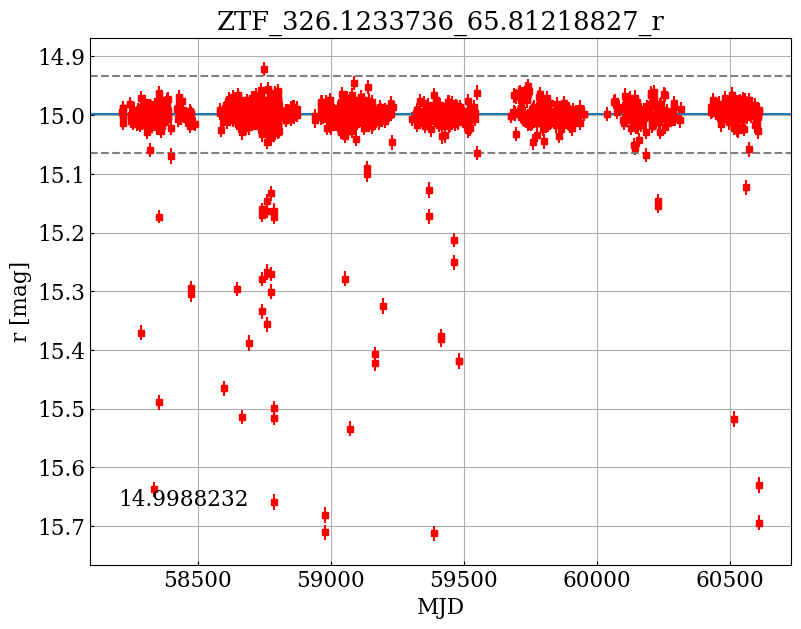

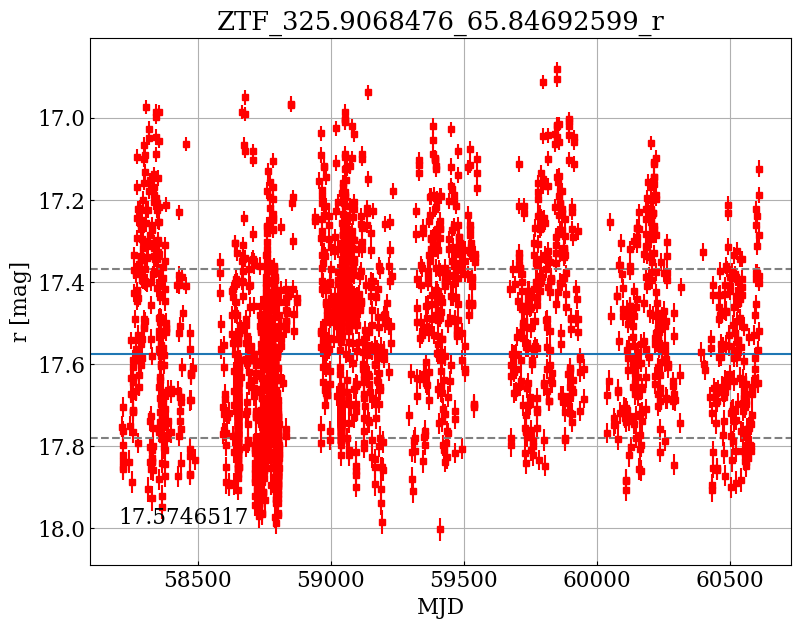

In [9]:
#fig, ax = plt.subplots(5,1, figsize=(10,10))
#fig, ax = plt.subplots(1,1, figsize=(10, 8))

#for i in np.arange(1,3): # <----- pick a few
for i in np.arange(1,len(files)):   # <----- run the whole directory
    fig, ax = plt.subplots(1,1, figsize=(8,6)) #you can change the size of this
    axs = ax

    lc = pd.read_csv(datadir + files[i])
    if len(lc["mjd"]) > 0: 
    
      axs.errorbar(lc["mjd"], lc["mag"], yerr=lc["magerr"], markersize=5, color="red", fmt='s')
                      #alpha=\=9 statistics.stdev([lc])
      #do statistics using np.something(standard deviation) on lc["mag"] --> make it a variable and print on plot
      #print(statistics.stdev(lc["mag"]), np.median(lc["magerr"]))

  
      axs.axhline(statistics.median(lc["mag"]))
      lcmedian = statistics.median(lc["mag"])
      sd = statistics.stdev(lc["mag"])
    
      print(files[i])
      #print((lc["mag"]).ndim) 
      print("Number of measurements in the lightcurve: ",len(lc["mag"]))
      print("Standard deviation of MAGNITUDES: ", sd)
      print("Median of magnitude ERROR: % s" % (statistics.median(lc["magerr"])))
      print("Signal-to-noise in the variability: % s " % (statistics.stdev(lc["mag"])/(statistics.median(lc["magerr"]))) )
      print(" ")
                  
      plt.axhline(lcmedian + sd, color='gray', linestyle='--')
      plt.axhline(lcmedian - sd, color='gray', linestyle='--')

      plt.text(58200, plt.ylim()[1]-0.1, lcmedian)
      #format to use only two significant figures for median
      #bottom y, top y, difference --> put it at ~90% of the y axis 
      #axs.ymax / xmax 
      #also give value of SD error lines 
      #how many data points are above/below the SD lines? state the number 

   
      plt.tight_layout()   

      #plt.legend([standev, 'second']);
      axs.set_xlabel("MJD")
      axs.set_ylabel("r [mag]")
      axs.invert_yaxis()
      axs.grid()
      axs.set_title(files[i][:-4])

      plt.savefig(plotdir + files[i] + ".png")

    else: pass 
      